# Evaluation with ImageNet excluding error data

In this notebook, we revaluate the published pretrained models with ImageNet excluding error data.  

ImageNet is used as a benchmark for the image classification task, but the presence of error data may prevent proper evaluation of the model.  
Therefore, we revaluate the models published on torchvision with the evaluation dataset excluded the error data which is reported in [this paper](https://arxiv.org/abs/2006.07159). 

Error data is shared in json format in [the repository](https://github.com/google-research/reassessed-imagenet/blob/master/real.json), but we wrote it down to a csv file to take advantage of Adansons Base in this validation.(You can use `error_data.csv`)  

In this Notebook, we revaluate the models with the following steps.  
1. Download ImageNet and extract it into a folder structure
2. Extract and orginize metadata of ImageNet with Adansons Base
3. Define a dataset class that overlaps Base and then revaluate the models.

## 1. Download ImageNet dataset  
First, please register as an ImageNet user [here](https://image-net.org/signup.php).  
After approved, please download 2012 `validation images(all task)` in the same directory.  

## 2. Expand ImageNet into a folder structure with prepro_imagenet.sh

In [ ]:
!sh prepare.sh

## 3. Install Adansons Base with `pip`

In [ ]:
!pip install git+https://github.com/adansons/base

## 4. Create new project
You can create new project via `base new` command.  
Here, we will create a project named imagenet

In [1]:
!base new imagenet

Your Project UID
----------------
123456789abcdefghijk

save Project UID in local file (~/.base/projects)


## 5. Import data files
Next, add ImageNet to the `imagenet` project.  

You have to specify your dataset directory and file extension via `--directory` and `--extension` option.  
Also, you need to specify the parsing rule via `--parse` option; it automatically parses and links dataset information in the path name according to given parsing rule.

In [2]:
# This could take time depending on the the data amount
# It could take around 2 mins on the MNIST dataset size (= 50000 files)
!base import imagenet --directory imagenet --extension JPEG --parse "{dataType}/{label}/{id}.JPEG"

Check datafiles...
found 50000 files with JPEG extension.
50000/50000 files uploaded.                        
Success!


## 6. Import external metadata files
Import `error_data.csv`, which summarize ImagenNet error data reported by Google.  
If you get an error message `Failed to join the table`, this processing continues internally. (It takes about 5 minutes)  
So, **you should run `project.attrs` to check that the processing have finished.**

In [3]:
from base import Project
project = Project('imagenet')

# Specify join rules with project tables like `{"New table key": "Exist table key"}
# if you have new key, replace "Exist table key" with None
join_rule = {
    "id": "id",
    "originalLabel": None,
    "correction": None
}
# add metafile
project.add_metafile(
    file_path=["error_data.csv"],
    join_rule=join_rule,
    auto=True
)

1 tables found! (error_data.csv)

1 table joining rule was estimated!

Below table joining rule will be applied...


Rule no.1

	key 'id'	->	connected to 'id' key on exist table
	key 'originalLabel'	->	newly added
	key 'correction'	->	newly added

1 tables will be applied
Table 1 sample record:
	{'id': 'ILSVRC2012_val_00023277', 'originalLabel': 582, 'correction': '930,963,868,923,813,415'}
Success!


In [4]:
# Check to see if the tables have been joined
project = Project('imagenet')
project.attrs

{'id': {'LowerValue': 'ILSVRC2012_val_00000001',
  'UpperValue': 'ILSVRC2012_val_00050000',
  'ValueType': 'str',
  'RecordedCount': 49971},
 'correction': {'LowerValue': '0',
  'UpperValue': '-1',
  'ValueType': 'str',
  'RecordedCount': 14264},
 'label': {'LowerValue': 'n01440764',
  'UpperValue': 'n15075141',
  'ValueType': 'str',
  'RecordedCount': 49971},
 'dataType': {'LowerValue': 'val',
  'UpperValue': 'val',
  'ValueType': 'str',
  'RecordedCount': 49971},
 'originalLabel': {'LowerValue': '0',
  'UpperValue': '999',
  'ValueType': 'int',
  'RecordedCount': 14264}}

## 6-1. Breakdown of error data

The contents of the external metafile used in this verification are as follows

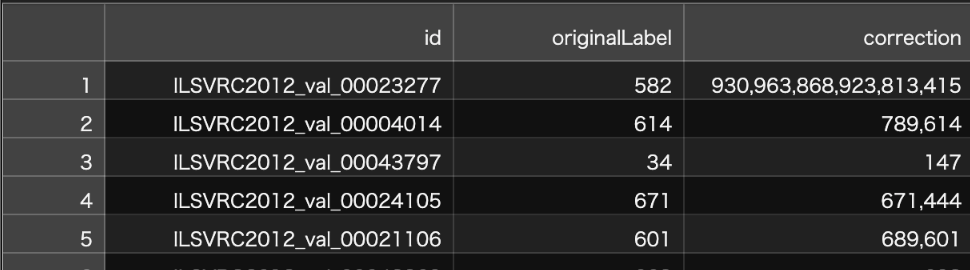

Id: Image file name  
Original Label: ImageNet's original label  
Correction: Correct label  
In Correction, we have “-1”: no label match data, “multilabel”: multiple numbers separated with comma, and “mislabel”: only one number.  
In this verification, since it is difficult to query which elements include commas or not with Base, we will create a Dataset class with the original filter processor. 

In [5]:
all_data = project.files()

# miss labeled data
miss_label_data = [record for record in all_data.items if "," not in record.get("correction", ",") and record.get("correction")!="-1"]
print(f"Miss label data size : {len(miss_label_data)}")

# multilabel data
multilabel_data = [record for record in all_data.items if "," in record.get("correction", "")]
print(f"Multilabel data size : {len(multilabel_data)}")

# the data which do not match any labels
no_label_match_data = project.files(query=["correction == -1"])
print(f"No label match data size : {len(no_label_match_data)}")

# toral error data
total_error_data = no_label_match_data = project.files(query=["correction is not None"])
print(f"Total error data size : {len(total_error_data)}")


Miss label data size : 3670
Multilabel data size : 7432
No label match data size : 3162
Total error data size : 14264


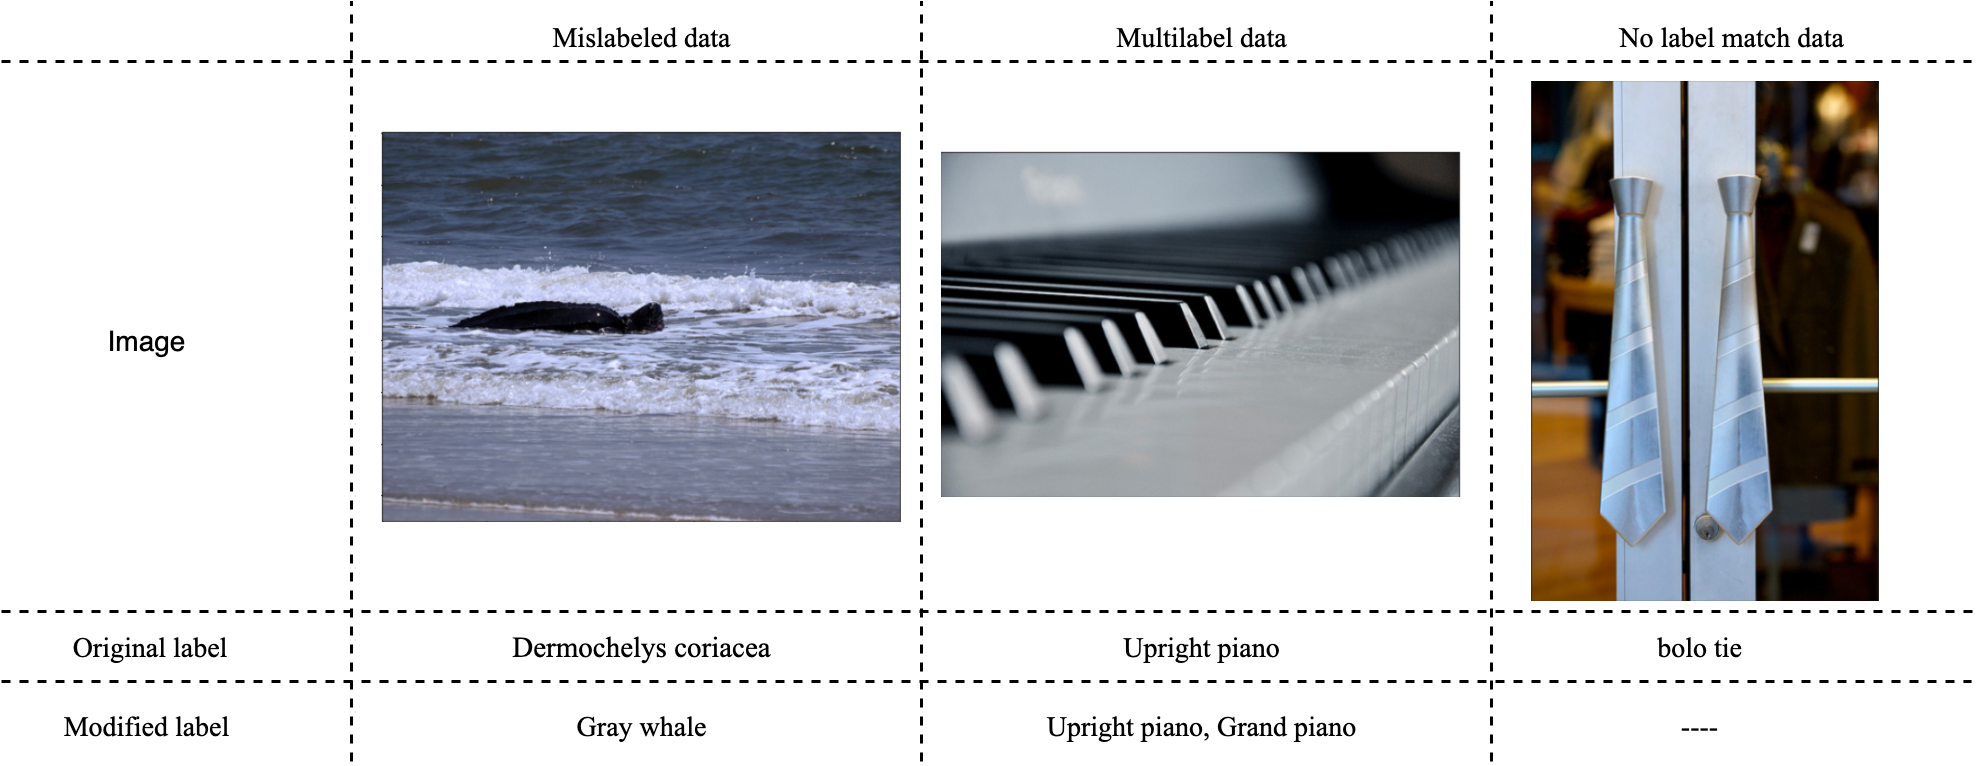

## 7. Define Dataset class & preprocess function
Define a dataset class excluding the data you want to remove.  
Image preprocessing functions are used in the dataset class.

In [ ]:
!pip install torch torchvision pillow tqdm

Import the necessary modules

In [6]:
from base import Project, Dataset
from base.files import Files

import torch
import torch.nn.parallel
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.models as models
from tqdm import tqdm
import pprint
from typing import Callable, Optional, Tuple
from PIL import Image

Adansons Base makes it easy to create dataset class as follows  
```Python
from base import Project, Dataset
import torch

# Make your project instance and filter the data that you want
project = Project("your-project")
files = project.files(query=["label in ['1', '2', '3']"])

# Create dataset class of Adansons Base with some arguments
#  - files      : Filtered data
#  - target_key : Column name of the correct label stored in Adansons Base
#  - transform  : Function to convert file paths to some information like Tensor or ndarray etc.
dataset = Dataset(files, target_key="label", transform=preprocess_func)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
```
If you want more detailed usage for Adansons Base, please check [this document](../docs/SDK.md).

However, the query for this validation cannot be executed with Base, so it is necessary to filter the data with original filtering function.  
So this time, we defined a new Dataset class that has the original filtering function and inherits from the Adansons Base Dataset class.

In [7]:
# Dataset excluding error data
class ImageNetDataset(Dataset):
    def __init__(
        self,
        files: Files,
        target_key: str,
        model_name: str,
        filter_mode: str,
        transform: Optional[Callable] = None,
    ) -> None:
    
        super().__init__(files, target_key, transform)
        self.external_filter(filter_mode)
        self.y = sorted(set([getattr(i, self.target_key) for i in files]))
        self.convert_dict = {i: j for j, i in enumerate(self.y)}
        self.model_name = model_name

    def __getitem__(self, idx: int) -> Tuple:
        path = self.dataset[idx][1]
        data = self.transform(path, self.model_name)
        label = self.dataset[idx][0].get(self.target_key)
        label = self.convert_dict[label]
        return data, label
    
    def external_filter(self, mode):
        if mode=="misslabel":
            self.dataset = [[record, path] for record, path in zip(self.files.items, self.paths) if not ("," not in record.get("correction", ",") and record.get("correction")!="-1")]
        else:
            self.dataset = [[record, path] for record, path in zip(self.files.items, self.paths) if not record.get('correction', False)]
        
    def __len__(self):
        return len(self.dataset)


# Functions for image preprocessing
def preprocess_image(image_path, model_name):
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
    )
    # convert gray to rgb if needed
    image = Image.open(image_path)
    if image.mode != "RGB":
        image = image.convert("RGB")

    sizes = {
        "convnext_large": (232, 224),
        "efficientnet_b7": (633, 600),
        "convnext_base": (232, 224),
        "convnext_small": (230, 224),
        "efficientnet_b5": (489, 456),
        "vit_b_16": (256, 224),
        "regnet_x_32gf": (256, 224),
        "efficientnet_b3": (320, 300),
        "convnext_tiny": (236, 224),
        "efficientnet_b4": (384, 380),
    }
    # last two letters of model_name
    if "efficientnet" in model_name:
        interpolation = transforms.InterpolationMode.BICUBIC
    else:
        interpolation = transforms.InterpolationMode.BILINEAR
    resize_size = sizes[model_name][0]
    crop_size = sizes[model_name][1]
    image = transforms.Resize(resize_size, interpolation=interpolation)(image)
    image = transforms.CenterCrop(crop_size)(image)
    image = transforms.ToTensor()(image)
    image = normalize(image)
    return image

## 8. Evaluation

Evaluate the following 10 models pretrained on ImageNet and available on torchvison.  
* convnext_large
* EfficientNet-B7
* convnext_base
* convnext_small
* EfficientNet-B5
* vit_b_16
* regnet_x_32gf
* EfficientNet-B3
* convnext_tiny
* EfficientNet-B4  

The following three types of data are used in the evaluation
* The dataset excluded all error data from ImageNet
* The dataset excluded mislabeled data from ImageNet
* Vanilla ImageNet

In [8]:
def eval(model_funcs, val_loader):
    res = {}
    for model_name, model_func in model_funcs.items():
        model = model_func(pretrained=True)
        model.eval()
        model.to("cuda")
        accs = []
        with torch.no_grad():
            for (images, target) in tqdm(val_loader, desc=f"Evaluating {model_name}...", leave=False):
                output = model(images.to("cuda"))
                acc = accuracy(output, target.to("cuda"))
                accs.append(acc)
        accs = torch.tensor(accs)
        res[model_name] = {"history": accs, "mean": accs.mean()}

    return res

def accuracy(output, target, topk=(1, 5)):

    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(
            maxk, 1, True, True
        )  # pred : indices. topk : get topk tensors along dim = 1 (within 1000 classes)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))
        
        correct = correct[:1].reshape(-1).float().sum(0, keepdim=True)
        top1_accs = correct.mul_(100 / batch_size)

        return top1_accs

First, evaluate the models on ImageNet without **all error data**

In [9]:
batch_size = 32

model_funcs = {
    "convnext_large": models.convnext_large,
    "efficientnet_b7": models.efficientnet_b7,
    "convnext_base": models.convnext_base,
    "convnext_small": models.convnext_small,
    "efficientnet_b5": models.efficientnet_b5,
    "vit_b_16": models.vit_b_16,
    "regnet_x_32gf": models.regnet_x_32gf,
    "efficientnet_b3": models.efficientnet_b3,
    "convnext_tiny": models.convnext_tiny,
    "efficientnet_b4": models.efficientnet_b4,
}

# in order to get the correct label, you need to use the all files
all_files = Project("imagenet").files()

# Start evaluation
res_py = {}
for model_name, model_func in model_funcs.items():
    val_dataset = ImageNetDataset(
        files=all_files,
        target_key="label",
        transform=preprocess_image,
        filter_mode="all",
        model_name=model_name,
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size
    )

    res = eval({model_name: model_func}, val_loader)
    # cast data to python list
    for k, v in res.items():
        res_py[k] = v["mean"].item()

pprint.pprint(res_py)

{'convnext_base': 95.36238861083984,
 'convnext_large': 95.57799530029297,
 'convnext_small': 95.07292938232422,
 'convnext_tiny': 94.44952392578125,
 'efficientnet_b3': 94.20870971679688,
 'efficientnet_b4': 95.14625549316406,
 'efficientnet_b5': 94.9306411743164,
 'efficientnet_b7': 95.31809997558594,
 'regnet_x_32gf': 92.9654312133789,
 'vit_b_16': 93.31265258789062}


Next, evaluate the models on ImageNet without **mislabeled data**

In [11]:
res_py = {}
for model_name, model_func in model_funcs.items():
    val_dataset = ImageNetDataset(
        files=all_files,
        target_key="label",
        transform=preprocess_image,
        filter_mode="misslabel",
        model_name=model_name,
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size
    )

    res = eval({model_name: model_func}, val_loader)
    # cast data to python list
    for k, v in res.items():
        res_py[k] = v["mean"].item()

pprint.pprint(res_py)

{'convnext_base': 87.18424224853516,
 'convnext_large': 87.4585189819336,
 'convnext_small': 86.74517059326172,
 'convnext_tiny': 85.61805725097656,
 'efficientnet_b3': 85.14725494384766,
 'efficientnet_b4': 86.53419494628906,
 'efficientnet_b5': 86.43894958496094,
 'efficientnet_b7': 87.10604858398438,
 'regnet_x_32gf': 83.70677185058594,
 'vit_b_16': 84.16291046142578}


Finally, evaluate the models on **vanilla ImageNet**

In [12]:
import torchvision.datasets as datasets

def load_val_loader(val_dir, model_name):

    sizes = {
        "convnext_large": (232, 224),
        "efficientnet_b7": (633, 600),
        "convnext_base": (232, 224),
        "convnext_small": (230, 224),
        "efficientnet_b5": (489, 456),
        "vit_b_16": (256, 224),
        "regnet_x_32gf": (256, 224),
        "efficientnet_b3": (320, 300),
        "convnext_tiny": (236, 224),
        "efficientnet_b4": (384, 380),
    }
    # last two letters of model_name
    resize_size = sizes[model_name][0]
    crop_size = sizes[model_name][1]
    if "efficientnet" in model_name:
        interpolation = transforms.InterpolationMode.BICUBIC
    else:
        interpolation = transforms.InterpolationMode.BILINEAR
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
    )
    val_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(
            val_dir,
            transforms.Compose(
                [
                    transforms.Resize(resize_size, interpolation),
                    transforms.CenterCrop(crop_size),
                    transforms.ToTensor(),
                    normalize,
                ]
            ),
        ),
        batch_size=32,
        num_workers=0,
        pin_memory=True,
    )
    return val_loader

val_loader = load_val_loader(
    model_name=model_name, val_dir="./imagenet/val/"
)

res_py = {}
for model_name, model_func in model_funcs.items():
    val_loader = load_val_loader(
        model_name=model_name, val_dir="./imagenet/val/"
    )
    res = eval({model_name: model_func}, val_loader)
    # cast data to python list
    for k, v in res.items():
        res_py[k] = v["mean"].item()

pprint.pprint(res_py)

The following table summarizes the results of the evaluation so far. (Values are in % accuracy, ranks in parentheses)

|     | All eval data    | Except mislabeled data    | Except all error data    | 
| :---: | :---: | :---: | :---: | 
| convnext_large    | 84.409 (1)   | 87.459 (1)   | 95.578 (1)    | 
| convnext_base    | 84.057 (2)   | 87.184 (2)   | 95.362 (2)   | 
| Efficientnet-B7    | 83.927 (3)   | 87.106 (3)   | 95.318 (3)   | 
| convnext_small    | 83.629 (4)   | 86.745 (4)   | 95.037 (5)   | 
| EfficientNet-B4    | 83.389 (5)   | 86.534 (5)   | 95.146 (4)   | 
| EfficientNet-B5    | 83.277(6)    | 86.439 (6)   | 94.931 (6)   | 
| convnext_tiny    | 82.504 (7)   | 85.618 (7)   | 94.450 (7)   | 
| EfficientNet-B3    | 82.016 (8)   | 85.147 (8)   | 94.209 (8)   | 
| vit_b_16    | 81.064 (9)   | 84.163 (9)   | 93.313 (9)   | 
| regnet_y_32gf    | 80.610 (10)   | 83.707 (10)   | 92.965 (10)   | 

Thus, when evaluated on data without error labels, which would be easy to mistake compared to clean data, the accuracy is improved across the board.    
It is particularly interesting to note that there is variation in the model's accuracy ranking when the model is evaluated without excluding error data, when some of the error data is excluded, and when all of the error data is excluded.   
This cannot deny the possibility that previous studies have drawn erroneous conclusions when comparing accuracy.  
Thus, it goes without saying that accurately labeled data should be used to evaluate the model.
In addition, although it was not done in this verification, it is important to use accurately labeled data not only during evaluation, but also during training.  

When it comes to practical application of AI in business, especially when we create our own datasets, creating high-quality datasets is directly related to increasing the accuracy and reliability of AI.  

The results of this verification show that simply improving the quality of the data increased accuracy by about 10 points, indicating the importance of improving not only the model but also the data set when developing an AI system.